# Credit Scoring - MODELLING
by Deviyanti Aryani Mariam

In this project, we will analyse a given historical borrowers data and will use supervised learning techniques to build credit scoring model. Then, we also will decide the threshold of the score or probability to default that can give us default rate below 3% and approval rate higher than 70%. The credit scorecard will also be provided to help nontechnical team use our model aligning with their plan.


The notebook focuses on Modeling. That includes data cleansing, feature engineering and Evaluation. To see Exploratory Data Analysis, open the other one jupyter file <b> Credit Scoring - EDA </b>

Stages:
- Import libraries
- Load data, look at data size, structure, missing values
- Data preparation (handling missing values, standardize, splitting, encoding)
- Feature selection
- Modeling, hyperparameter tuning
- Evaluation


## Import Libraries

- `datetime` - library to work with date and time
- `math` - basic mathematical functions
- `numpy` - for mathematical,and numerical calculations
- `scipy` - for metrics evaluation calculations
- `pandas` - for data analysis and manipulation
- `scikit` - machine learning library
- `matplotlib` - for visualisation
- `seaborn` - for visualisation
- `xgboost` - gradient boosting used for training the models
- `shap plot` - for shap plot

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from scipy.stats import ks_2samp
from xgboost import plot_importance
%matplotlib inline
pd.set_option('display.max_columns', None) 


## Load Data

In [63]:
def read_file(path):
    """
    open a csv file and shows data size, missing values, type
    
    input: file path (string)
    output: dataframe
    """
    
    data=pd.read_csv(path)
    print('SHAPE',data.shape)
    print('=========================')# Investigate null rate of contained null columns
    print('MISSING VALUES')
    print('column, total_row_missing, missing value ratio')
    df_missing_rate=pd.DataFrame([],columns=['column','total_row_missing','missing_value_rate'])
    for i,j in zip(data.columns,data.isna().sum()):
        if j>0:
            df_missing_rate=df_missing_rate.append({'column':i,'total_row_missing':j,'missing_value_rate':'{}%'.format(data[i].isnull().sum()*100 / data.shape[0])},ignore_index=True) 
    print(df_missing_rate)
    print('=========================')
    print('TYPE\n{}'.format(data.dtypes))
    return data,df_missing_rate

In [89]:
file_path='data.csv'
df,df_missing_rate=read_file(file_path)
df.head()

SHAPE (15645, 24)
MISSING VALUES
column, total_row_missing, missing value ratio
                 column total_row_missing    missing_value_rate
0      total_cash_usage                45  0.28763183125599234%
1           branch_code               195      1.2464046021093%
2  overlimit_percentage                26  0.16618728028124002%
3     delinquency_score                88    0.562480025567274%
4    utilization_6month              2842   18.165548098434005%
TYPE
X                                       int64
number_of_cards                         int64
outstanding                             int64
credit_limit                          float64
bill                                  float64
total_cash_usage                      float64
total_retail_usage                    float64
remaining_bill                        float64
branch_code                            object
payment_ratio                         float64
overlimit_percentage                  float64
payment_ratio_3month     

,X,number_of_cards,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,branch_code,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,default_flag,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,remaining_bill_per_limit,total_usage_per_limit,total_3mo_usage_per_limit,total_6mo_usage_per_limit,utilization_3month,utilization_6month
0,2,2,268691,10000000.0,254564.0,0.0,1012.0,0.0,A,0.00,0.0,0.00,0.00,NaN,0,0.750000,1012.0,0.0,0.000000,0.000101,0.000000,0.000000,0.004232,0.000300
1,3,3,6769149,28000000.0,4159779.0,0.0,0.0,0.0,A,100.00,0.0,100.00,100.91,NaN,0,10.750000,0.0,0.0,0.000000,0.000000,0.040518,0.047703,0.249389,NaN
2,5,2,9402085,10000000.0,6099283.0,0.0,2666558.0,5951865.0,A,95.99,0.0,97.49,99.84,NaN,0,1.666667,2666558.0,2975932.5,0.595186,0.266656,0.323027,0.131162,0.707865,0.336571
3,6,2,6227439,80000000.0,2081248.0,0.0,3690250.0,4613435.0,A,0.00,0.0,28.46,42.03,NaN,0,10.250000,3690250.0,2306717.5,0.057668,0.046128,0.017184,0.117513,0.038964,0.181863
4,7,2,3906290,4000000.0,2043682.0,0.0,230400.0,3314046.0,A,18.47,0.0,24.95,17.89,NaN,0,4.666667,230400.0,1657023.0,0.828511,0.057600,0.018750,0.166667,1.014776,0.977231


In [90]:
df_missing_rate

,column,total_row_missing,missing_value_rate
0,total_cash_usage,45,0.28763183125599234%
1,branch_code,195,1.2464046021093%
2,overlimit_percentage,26,0.16618728028124002%
3,delinquency_score,88,0.562480025567274%
4,utilization_6month,2842,18.165548098434005%


## DATA PREPARATION

In [91]:
df.set_index('X',inplace=True)

In [92]:
# Classify features into either numerical or categorical
col_target = 'default_flag'
col_list = list(df.drop(col_target,axis=1).columns)
col_numerical = list(df[col_list].select_dtypes(include=np.number).columns)
col_categorical = list(df[col_list].select_dtypes(include=np.object).columns)
print('NUMERICAL:',len(col_numerical),'out of',len(col_list), 'columns')
[ print(i) for i in col_numerical]
print('=========================')
print('CATEGORICAL:',len(col_categorical),'out of',len(col_list), 'columns')
for i in col_categorical:
    print(i)

NUMERICAL: 21 out of 22 columns
number_of_cards
outstanding
credit_limit
bill
total_cash_usage
total_retail_usage
remaining_bill
payment_ratio
overlimit_percentage
payment_ratio_3month
payment_ratio_6month
delinquency_score
years_since_card_issuing
total_usage
remaining_bill_per_number_of_cards
remaining_bill_per_limit
total_usage_per_limit
total_3mo_usage_per_limit
total_6mo_usage_per_limit
utilization_3month
utilization_6month
CATEGORICAL: 1 out of 22 columns
branch_code


In [93]:
# Check whether there is any duplicate data based on the user_id
df[df.index.duplicated()]

,number_of_cards,outstanding,credit_limit,bill,total_cash_usage,total_retail_usage,remaining_bill,branch_code,payment_ratio,overlimit_percentage,payment_ratio_3month,payment_ratio_6month,delinquency_score,default_flag,years_since_card_issuing,total_usage,remaining_bill_per_number_of_cards,remaining_bill_per_limit,total_usage_per_limit,total_3mo_usage_per_limit,total_6mo_usage_per_limit,utilization_3month,utilization_6month
X,,,,,,,,,,,,,,,,,,,,,,,


In [94]:
# Check the descriptive statistics
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
number_of_cards,15645,NaN,NaN,NaN,2.50604,1.01254,1,2,2,3,16
outstanding,15645,NaN,NaN,NaN,1.16062e+07,2.40794e+07,0,1.9928e+06,4.71878e+06,1.06653e+07,7.98059e+08
credit_limit,15645,NaN,NaN,NaN,2.08201e+07,2.95542e+07,3e+06,5e+06,9e+06,2.2e+07,1e+09
bill,15645,NaN,NaN,NaN,8.07644e+06,1.75998e+07,20043,813947,3.14137e+06,7.40407e+06,6.28e+08
total_cash_usage,15600,NaN,NaN,NaN,74576.2,617787,0,0,0,0,2.88406e+07
total_retail_usage,15645,NaN,NaN,NaN,2.02481e+06,7.90934e+06,-1.56672e+07,0,200000,1.3962e+06,2.85e+08
remaining_bill,15645,NaN,NaN,NaN,8.1468e+06,1.92467e+07,0,0,2.74716e+06,7.14246e+06,4.44e+08
branch_code,15450,11,A,8705,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_ratio,15645,NaN,NaN,NaN,7.03689,792.912,-49860,-17.3,0,44.6,68983
overlimit_percentage,15619,NaN,NaN,NaN,3.33065,9.21515,0,0,0,1.01,190


In [95]:
# Check mode of categorical value
print('ratio of categorical feature value out of total data:')
print('null',round(len(df[df['branch_code'].isna()]) / len(df),7))
df.branch_code.value_counts() / len(df)

ratio of categorical feature value out of total data:
null 0.012464


A    0.556408
F    0.108469
B    0.086353
I    0.063343
E    0.041483
G    0.036178
J    0.026206
H    0.023458
C    0.021349
D    0.013103
K    0.011186
Name: branch_code, dtype: float64

As the null values of branch code is small number which is around 1.2%, we can subtitute null values to the most frequent branch code A 

In [96]:
df['branch_code'].fillna('A',inplace=True)

As we use Logistic Regression (LR) as our baseline model, we need to handle missing values and outliers because of LR's sensitivity toward them. We also choose XGBoost as our actual model and what makes it different is that Xgboost is quite robust on outliers.

In [105]:
#fill the missing value with mean
cols_num_missing = df[col_numerical].columns[df[col_numerical].isnull().any()].tolist()
for c in cols_num_missing:
    mean = df[c].mean()
    df[c+'_imp'] = df[c].fillna(mean,axis=0)

In [106]:
#split the data into train and test, detail as follows 80% for training dataset and 20% for test dataset
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='default_flag'),df['default_flag'],test_size=0.2,train_size=0.8,random_state=200)

Numerical - Standardization<br>
Scaling is performed on numerical predictors to avoid the outliers that some models are sensitive to. Standardization is one of the methods for scaling, it transformed all the values by centering its mean at 0 then scales the variance at 1.

The advantage of this method is it keeps the shape of the predictor's original distribution

In [108]:
# standardize all numerical columns
from sklearn.preprocessing import StandardScaler
cols_pred_num2 = list(map(lambda x: x+'_imp' if x in cols_num_missing else x, col_numerical))       
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(x_train[cols_pred_num2])
x_train_sd = scaler.transform(x_train[cols_pred_num2])
x_test_sd = scaler.transform(x_test[cols_pred_num2])

# stored the standardscaler output on cols_sd
cols_sd = [i+'_sd' for i in col_numerical]
x_train[cols_sd] = x_train_sd
x_test[cols_sd] = x_test_sd
x_train[cols_sd].head()

,number_of_cards_sd,outstanding_sd,credit_limit_sd,bill_sd,total_cash_usage_sd,total_retail_usage_sd,remaining_bill_sd,payment_ratio_sd,overlimit_percentage_sd,payment_ratio_3month_sd,payment_ratio_6month_sd,delinquency_score_sd,years_since_card_issuing_sd,total_usage_sd,remaining_bill_per_number_of_cards_sd,remaining_bill_per_limit_sd,total_usage_per_limit_sd,total_3mo_usage_per_limit_sd,total_6mo_usage_per_limit_sd,utilization_3month_sd,utilization_6month_sd
X,,,,,,,,,,,,,,,,,,,,,
10044,-0.496869,-0.221047,-0.062512,-0.416220,-0.120032,-0.186388,-0.277804,0.103819,-0.366323,0.036946,0.009541,-0.095037,-0.953911,-0.191335,-0.253044,-0.681890,-0.412609,-0.277227,-0.565346,-0.497509,-0.583885
3315,-0.496869,-0.420987,-0.524554,-0.434385,-0.120032,-0.248091,-0.416748,-0.127126,-0.366323,0.037742,0.009602,-0.095037,0.203835,-0.251684,-0.466634,-0.987404,-0.549380,-0.323674,-0.367031,-0.688352,-0.593988
4373,1.451381,0.270282,0.663553,0.122360,-0.120032,0.252779,-0.416748,-0.127126,-0.366323,0.037742,0.009602,-0.095037,-0.224167,0.238193,-0.466634,-0.987404,-0.033360,-0.143045,0.264294,-0.420206,-0.268172
4665,-0.496869,-0.441606,-0.590560,-0.419906,-0.120032,-0.176006,-0.416748,-0.127126,-0.366323,0.038466,0.009602,-0.095037,-0.722790,-0.181180,-0.466634,-0.987404,0.462619,1.054266,0.720846,-0.845375,-0.553577
14249,-0.496869,-0.378741,-0.491551,-0.328149,-0.120032,-0.242382,-0.310730,-0.010781,-0.366323,-0.012259,0.009602,-0.095037,-0.919671,-0.246099,-0.303660,-0.249956,-0.509300,-0.220458,-0.509704,-0.714926,-1.129943


as we have categorical features, we need to convert them to format that more expressive to train the model, we choose one hot encoding because the branch code is nominal type, it doesnt have ordering. If the feature is ordinal one, perhaps we can use label encoding. We also convert them after we split the data as we dont want to leak information from test set into the training set

In [109]:
# create one hot encoder object 
onehotencoder = OneHotEncoder(sparse=False)
x_train_hot = onehotencoder.fit_transform(x_train[['branch_code']])
# add this back into the original dataframe 
x_train_hot = pd.DataFrame(x_train_hot, columns = onehotencoder.get_feature_names(['branch_code'])) 
x_train = pd.concat([x_train.reset_index(), x_train_hot],axis=1)
x_train['type']='TRAIN'
del x_train_hot

In [110]:
# transform categorical data of test dataset into one hot label based on training data
x_test_hot=onehotencoder.transform(x_test[['branch_code']])
x_test_hot = pd.DataFrame(x_test_hot, columns = onehotencoder.get_feature_names(['branch_code'])) 
x_test = pd.concat([x_test.reset_index(), x_test_hot],axis=1)
x_test['type']='TEST'
del x_test_hot

In [111]:
list_file=[x_train,x_test]
x_combined=pd.concat(list_file,axis=0)

In [112]:
list_file=[y_train,y_test]
y_combined=pd.concat(list_file,axis=0)
data_combined=pd.merge(x_combined,y_combined.reset_index(),on='X')
del x_combined,y_combined

In [113]:
data_summary = data_combined.groupby(['type']).aggregate({col_target:['sum','count']})
data_summary.columns = [col_target, 'total_data']
data_summary[col_target+' rate'] = data_summary[col_target] / data_summary['total_data']

display(data_summary)

,default_flag,total_data,default_flag rate
type,,,
TEST,293,3129,0.093640
TRAIN,1123,12516,0.089725


table tells us that default data are almost equally partitioned between 2 datasets, but test dataset has higher default rate by 0.4%. The proportion between default and not default is imbalanced.

## Feature Selection

We already did exploratory data analysis on a seperate file, there are some features that may be good in distinguishing our label as their distribution plot across our labels are very different. We also can check their correlation toward our label as well as check their VIF (Variable Inflation Factors) because Logistic Regression is not robust to multicollinearity, choose features with high correlation to our label yet low VIF value for training LR model. On contrast, XGBoost is quite robust to multicollinearity. The lower VIF values are between the independent feature, The less the probability to experience multicollinearity

In [150]:
# calculate correlation
pd.DataFrame(df.corr()['default_flag'].abs().sort_values())

,default_flag
years_since_card_issuing,0.000589
payment_ratio,0.001038
payment_ratio_3month,0.007130
payment_ratio_6month,0.008944
total_cash_usage_imp,0.017121
total_cash_usage,0.017375
total_6mo_usage_per_limit,0.017959
number_of_cards,0.021001
credit_limit,0.028078
total_usage,0.049363


The data above shows that the features arent highly correlated to default flag (0.5-1 indicates high), yet there are some features that have very low correlation with the target variable, we can remove them and make sure features that will be chosen for Logistic Regression have low VIF value

In [126]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculate VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [128]:
scaled_column=['number_of_cards_sd',
 'outstanding_sd',
 'credit_limit_sd',
 'bill_sd',
 'total_cash_usage_sd',
 'total_retail_usage_sd',
 'remaining_bill_sd',
 'payment_ratio_sd',
 'overlimit_percentage_sd',
 'payment_ratio_3month_sd',
 'payment_ratio_6month_sd',
 'delinquency_score_sd',
 'years_since_card_issuing_sd',
 'total_usage_sd',
 'remaining_bill_per_number_of_cards_sd',
 'remaining_bill_per_limit_sd',
 'total_usage_per_limit_sd',
 'total_3mo_usage_per_limit_sd',
 'total_6mo_usage_per_limit_sd',
 'utilization_3month_sd',
 'utilization_6month_sd']
calc_vif(data_combined[scaled_column])

,variables,VIF
0,number_of_cards_sd,1.710914
1,outstanding_sd,10.268372
2,credit_limit_sd,3.152320
3,bill_sd,5.484028
4,total_cash_usage_sd,3378.933001
5,total_retail_usage_sd,553488.875383
6,remaining_bill_sd,12.246902
7,payment_ratio_sd,1.003176
8,overlimit_percentage_sd,1.452046
9,payment_ratio_3month_sd,1.099773


VIF higher than 10 indicates high multicollinearity between this independent variable and the others. So for building our baseline model, the following features would be discarded: 
- total_usage_sd
- total_retail_usage_sd
- total_cash_usage_sd

In [133]:
[i for i in data_combined.columns]

['X',
 'number_of_cards',
 'outstanding',
 'credit_limit',
 'bill',
 'total_cash_usage',
 'total_retail_usage',
 'remaining_bill',
 'branch_code',
 'payment_ratio',
 'overlimit_percentage',
 'payment_ratio_3month',
 'payment_ratio_6month',
 'delinquency_score',
 'years_since_card_issuing',
 'total_usage',
 'remaining_bill_per_number_of_cards',
 'remaining_bill_per_limit',
 'total_usage_per_limit',
 'total_3mo_usage_per_limit',
 'total_6mo_usage_per_limit',
 'utilization_3month',
 'utilization_6month',
 'total_cash_usage_imp',
 'overlimit_percentage_imp',
 'delinquency_score_imp',
 'utilization_6month_imp',
 'number_of_cards_sd',
 'outstanding_sd',
 'credit_limit_sd',
 'bill_sd',
 'total_cash_usage_sd',
 'total_retail_usage_sd',
 'remaining_bill_sd',
 'payment_ratio_sd',
 'overlimit_percentage_sd',
 'payment_ratio_3month_sd',
 'payment_ratio_6month_sd',
 'delinquency_score_sd',
 'years_since_card_issuing_sd',
 'total_usage_sd',
 'remaining_bill_per_number_of_cards_sd',
 'remaining_bill_

## MODELING

The used metric will be AUC because in credit scoring, people choose Gini as their performance metric, it help us measure how good a credit score is at predicting who will repay and who will default on a loan. GINI = 2 * AUC - 1

### Model BASELINE (Logistic Regression)
we take the following transformed(Imputation-Standardization) numerical features and one categorical feature

In [143]:
from sklearn.linear_model import LogisticRegression

log_features=['number_of_cards_sd',
 'outstanding_sd',
 'credit_limit_sd',
 'bill_sd',
#  'total_cash_usage_sd',
#  'total_retail_usage_sd',
 'remaining_bill_sd',
 'payment_ratio_sd',
 'overlimit_percentage_sd',
 'payment_ratio_3month_sd',
 'payment_ratio_6month_sd',
 'delinquency_score_sd',
 'years_since_card_issuing_sd',
#  'total_usage_sd',
 'remaining_bill_per_number_of_cards_sd',
 'remaining_bill_per_limit_sd',
 'total_usage_per_limit_sd',
 'total_3mo_usage_per_limit_sd',
 'total_6mo_usage_per_limit_sd',
 'utilization_3month_sd',
 'utilization_6month_sd',
 'branch_code_A',
 'branch_code_B',
 'branch_code_C',
 'branch_code_D',
 'branch_code_E',
 'branch_code_F',
 'branch_code_G',
 'branch_code_H',
 'branch_code_I',
 'branch_code_J',
 'branch_code_K',]

logreg = LogisticRegression(solver='lbfgs', max_iter=500, random_state=10)
logreg.fit(x_train[log_features],y_train)
logreg_proba=logreg.predict_proba(x_test[log_features])[:,1]

In [208]:
# Calculate AUC Baseline
from sklearn import metrics
fpr_lr_test, tpr_lr_test, thresholds = metrics.roc_curve(y_test,logreg_proba, pos_label=1)
fpr_lr_train, tpr_lr_train, thresholds = metrics.roc_curve(y_train,logreg.predict_proba(x_train[log_features])[:,1], pos_label=1)
print('AUC of Baseline (Test set)', metrics.auc(fpr_lr_test, tpr_lr_test))

AUC of Baseline (Test set) 0.7704320847995302


Apart from splitting dataset randomly into test and train dataset, we may need stratified cross validation as our data is imbalanced. We also can perform hyperparameter tuning with the chosen score is AUC.

In [151]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [152]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [153]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1,use_label_encoder=False)

In [154]:
x_train.columns

Index(['X', 'number_of_cards', 'outstanding', 'credit_limit', 'bill',
       'total_cash_usage', 'total_retail_usage', 'remaining_bill',
       'branch_code', 'payment_ratio', 'overlimit_percentage',
       'payment_ratio_3month', 'payment_ratio_6month', 'delinquency_score',
       'years_since_card_issuing', 'total_usage',
       'remaining_bill_per_number_of_cards', 'remaining_bill_per_limit',
       'total_usage_per_limit', 'total_3mo_usage_per_limit',
       'total_6mo_usage_per_limit', 'utilization_3month', 'utilization_6month',
       'total_cash_usage_imp', 'overlimit_percentage_imp',
       'delinquency_score_imp', 'utilization_6month_imp', 'number_of_cards_sd',
       'outstanding_sd', 'credit_limit_sd', 'bill_sd', 'total_cash_usage_sd',
       'total_retail_usage_sd', 'remaining_bill_sd', 'payment_ratio_sd',
       'overlimit_percentage_sd', 'payment_ratio_3month_sd',
       'payment_ratio_6month_sd', 'delinquency_score_sd',
       'years_since_card_issuing_sd', 'total_usage_

### Model 2 using features below

In [155]:
col_to_predict=['number_of_cards', 'outstanding', 'credit_limit', 'bill',
       'total_cash_usage', 'total_retail_usage', 'remaining_bill',
       'payment_ratio', 'overlimit_percentage',
       'payment_ratio_3month', 'payment_ratio_6month', 'delinquency_score',
       'years_since_card_issuing', 'total_usage',
       'remaining_bill_per_number_of_cards', 'remaining_bill_per_limit',
       'total_usage_per_limit', 'total_3mo_usage_per_limit',
       'total_6mo_usage_per_limit', 'utilization_3month', 'utilization_6month',
       'branch_code_A', 'branch_code_B', 'branch_code_C', 'branch_code_D',
       'branch_code_E', 'branch_code_F', 'branch_code_G', 'branch_code_H',
       'branch_code_I', 'branch_code_J', 'branch_code_K',]

In [156]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(x_train,y_train), verbose=3, random_state=1001 )
start_time = timer(None)
random_search.fit(x_train[col_to_predict], y_train)
timer(start_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  2.0min finished


[23:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 2 minutes and 26.87 seconds.


In [157]:
## best parameters of model 1 and predict test dataset
print('model 1')
xgb_final = random_search.best_estimator_
prediction=xgb_final.predict(x_test[col_to_predict])
print ('best_params:',random_search.best_params_,'auc:',random_search.best_score_)
prediction_proba=xgb_final.predict_proba(x_test[col_to_predict])[:,1]

model 1
best_params: {'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.8} auc: 0.8738425537542316


### Model 3 excludes years_since_card_issuing, payment_ratio, payment_ratio_3month, payment_ratio_6month  
We can experiment by removing features that have lower correlation to the target

In [161]:
col_to_predict2=['number_of_cards', 'outstanding', 'credit_limit', 'bill',
       'total_cash_usage', 'total_retail_usage', 'remaining_bill',
       'overlimit_percentage'
        ,'delinquency_score',
       'total_usage',
       'remaining_bill_per_number_of_cards', 'remaining_bill_per_limit',
       'total_usage_per_limit', 'total_3mo_usage_per_limit',
       'total_6mo_usage_per_limit', 'utilization_3month', 'utilization_6month',
       'branch_code_A', 'branch_code_B', 'branch_code_C', 'branch_code_D',
       'branch_code_E', 'branch_code_F', 'branch_code_G', 'branch_code_H',
       'branch_code_I', 'branch_code_J', 'branch_code_K',]

In [162]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search2 = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(x_train,y_train), verbose=3, random_state=1001 )
start_time = timer(None)
random_search2.fit(x_train[col_to_predict2], y_train)
timer(start_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.5min finished


[23:46:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 1 minutes and 50.91 seconds.


In [163]:
xgb_final2 = random_search2.best_estimator_

prediction2=xgb_final2.predict(x_test[col_to_predict2])

print ('best_params:',random_search2.best_params_,'auc:',random_search2.best_score_)
prediction_proba2=xgb_final2.predict_proba(x_test[col_to_predict2])[:,1]

best_params: {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 1.0} auc: 0.8592503317559129


## Evaluation and Model Selection

In [210]:
# calculate AUC model 2 XGB all features
fpr_xg_test2, tpr_xg_test2, thresholds = metrics.roc_curve(y_test,xgb_final.predict_proba(x_test[col_to_predict])[:,1], pos_label=1)
fpr_xg_train2, tpr_xg_train2, thresholds = metrics.roc_curve(y_train,xgb_final.predict_proba(x_train[col_to_predict])[:,1], pos_label=1)

# calculate AUC model 3 XGB selected features
fpr_xg_test3, tpr_xg_test3, thresholds = metrics.roc_curve(y_test,xgb_final2.predict_proba(x_test[col_to_predict2])[:,1], pos_label=1)
fpr_xg_train3, tpr_xg_train3, thresholds = metrics.roc_curve(y_train,xgb_final2.predict_proba(x_train[col_to_predict2])[:,1], pos_label=1)


In [218]:
df_auc=pd.DataFrame([],columns=['model','train_auc','test_auc'])
df_auc=df_auc.append({'model':'baseline (LR)','train_auc':metrics.auc(fpr_lr_train, tpr_lr_train),'test_auc':metrics.auc(fpr_lr_test, tpr_lr_test)},ignore_index=True)
df_auc=df_auc.append({'model':'XGB with all features','train_auc':metrics.auc(fpr_xg_train2, tpr_xg_train2),'test_auc':metrics.auc(fpr_xg_test2, tpr_xg_test2)},ignore_index=True)
df_auc=df_auc.append({'model':'XGB with selected features','train_auc':metrics.auc(fpr_xg_train3, tpr_xg_train3),'test_auc':metrics.auc(fpr_xg_test3, tpr_xg_test3)},ignore_index=True)
df_auc['train_gini']=df_auc['train_auc']*2-1
df_auc['test_gini']=df_auc['test_auc']*2-1
# show performance evaluation
df_auc






,model,train_auc,test_auc,train_gini,test_gini
0,baseline (LR),0.780434,0.770432,0.560868,0.540864
1,XGB with all features,0.966525,0.873918,0.933051,0.747835
2,XGB with selected features,0.923871,0.849346,0.847742,0.698691


<b> XGB with all features shows better performance on test dataset, yet considering the performance on train dataset, both XGB models may experience overfitting. Hence, we need to build a new model where the hyperparameter will be tuned to avoid overfitting.

### Model 4 XGBoost (Avoid Overfitting)
Hyperparameters are set up to satisfy reducing overfitting

In [220]:
params2 = {
        'min_child_weight': [10, 50, 100],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [221]:
xgb2 = XGBClassifier(colsample_bytree=0.6,gamma=2,learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1,use_label_encoder=False)

In [222]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search3 = RandomizedSearchCV(xgb2, param_distributions=params2, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(x_train,y_train), verbose=3, random_state=1001 )
start_time = timer(None)
random_search3.fit(x_train[col_to_predict2], y_train)
timer(start_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.5min finished


[00:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 1 minutes and 48.19 seconds.


In [223]:
xgb_final3 = random_search3.best_estimator_

prediction3=xgb_final3.predict(x_test[col_to_predict2])

print ('best_params:',random_search3.best_params_,'auc:',random_search3.best_score_)
prediction_proba3=xgb_final3.predict_proba(x_test[col_to_predict2])[:,1]

best_params: {'min_child_weight': 10, 'max_depth': 5, 'colsample_bytree': 0.8} auc: 0.8550282669343062


In [322]:
xgb_final3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [224]:
# calculate AUC model 4 XGB avoid overfitting
fpr_xg_test4, tpr_xg_test4, thresholds = metrics.roc_curve(y_test,xgb_final3.predict_proba(x_test[col_to_predict2])[:,1], pos_label=1)
fpr_xg_train4, tpr_xg_train4, thresholds = metrics.roc_curve(y_train,xgb_final3.predict_proba(x_train[col_to_predict2])[:,1], pos_label=1)

In [225]:
df_auc=df_auc.append({'model':'XGB avoid overfitting','train_auc':metrics.auc(fpr_xg_train4, tpr_xg_train4),'test_auc':metrics.auc(fpr_xg_test4, tpr_xg_test4),'train_gini':metrics.auc(fpr_xg_train4, tpr_xg_train4)*2-1,'test_gini':metrics.auc(fpr_xg_test4, tpr_xg_test4)*2-1},ignore_index=True)

In [226]:
df_auc

,model,train_auc,test_auc,train_gini,test_gini
0,baseline (LR),0.780434,0.770432,0.560868,0.540864
1,XGB with all features,0.966525,0.873918,0.933051,0.747835
2,XGB with selected features,0.923871,0.849346,0.847742,0.698691
3,XGB avoid overfitting,0.910536,0.843357,0.821072,0.686714


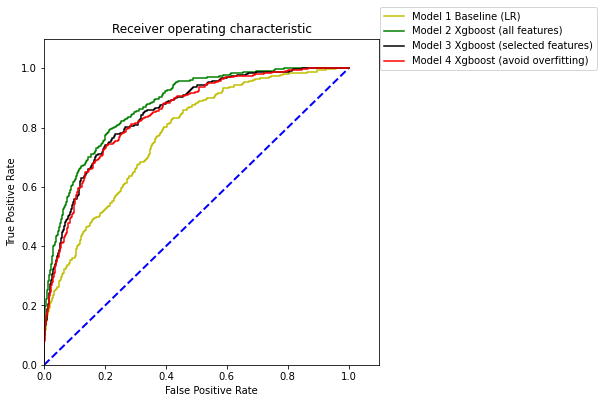

In [228]:
#Plot of a ROC curve
f, ax = plt.subplots(figsize=(6,6))
lw = 2
ax.plot(fpr_lr_test, tpr_lr_test, color='y',label='Model 1 Baseline (LR)')
ax.plot(fpr_xg_test2, tpr_xg_test2, color='g',label='Model 2 Xgboost (all features)')
ax.plot(fpr_xg_test3, tpr_xg_test3, color='k',label='Model 3 Xgboost (selected features)')
ax.plot([0, 1], [0, 1], color='b', lw=lw, linestyle='--') 
ax.plot(fpr_xg_test4, tpr_xg_test4, color='r',label='Model 4 Xgboost (avoid overfitting)')
ax.set_xlim([0.0, 1.1])
ax.set_ylim([0.0, 1.1])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(bbox_to_anchor=(1, 1.1), borderaxespad=0.1)
plt.show()

It shows that Model 2 has better performance on test dataset, yet Model 4 will be chosen as it has a reduced overfitting

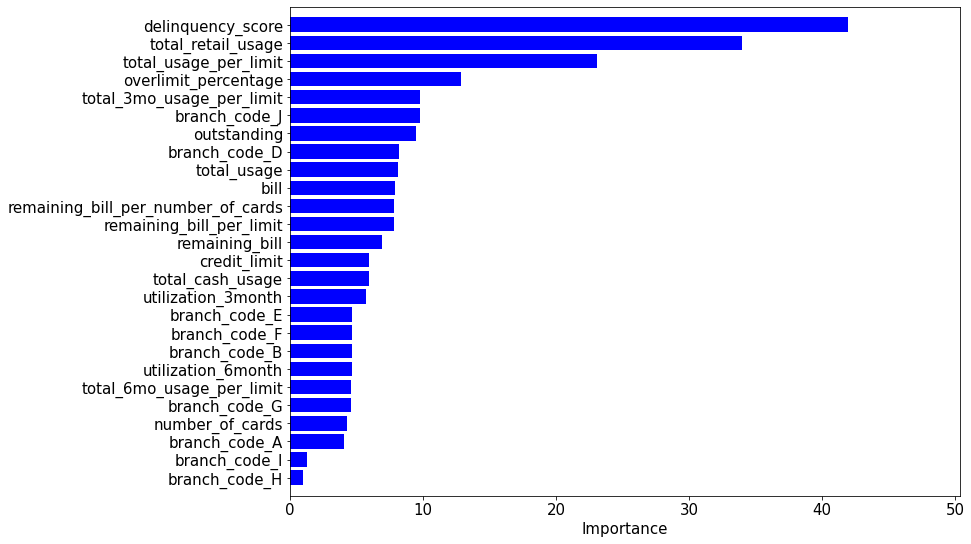

In [323]:
# Plot feature importance of model 4
gain_data = xgb_final3.get_booster().get_score(importance_type='gain')
imp = sorted([(k, v) for k, v in gain_data.items()], key = lambda x:x[1], reverse = True)
imp.reverse()

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.barh(range(len(imp)), [v for k, v in imp], color="blue",  align='center')
plt.yticks(range(len(imp)), [k for k, v in imp], fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Importance',fontsize=15)
plt.ylim([-1, len(imp)])
plt.xlim([0, max([v for k, v in imp])*1.2])
plt.show()

This bar plot tells us the predictor relative contribution on each of the tree in the model 2. **delinquency_score**, **total_retail_usage** and **total_usage_per_limit** are the highest contributors to the model

In [324]:
import shap 
explainer = shap.TreeExplainer(xgb_final3)

# Calculate Shap values
shap_values1 = explainer.shap_values(x_test[col_to_predict2].head(1000))


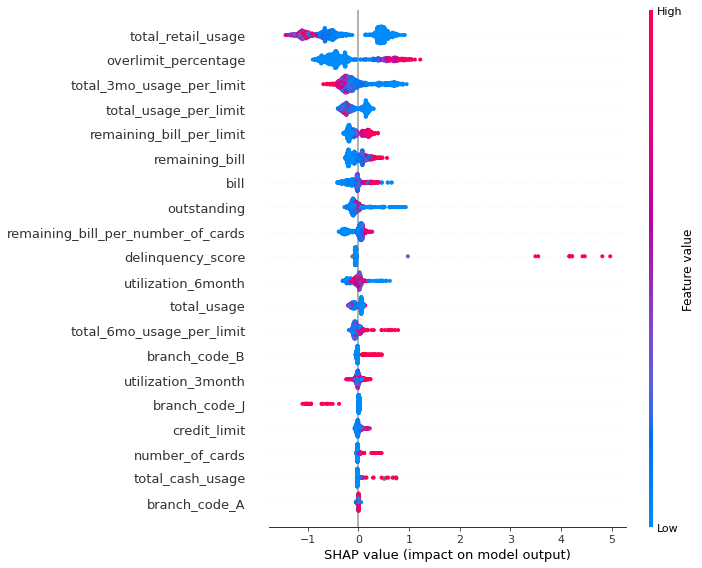

In [325]:
shap.summary_plot(shap_values1,x_test[col_to_predict2].head(1000))

Shap can help us explain the model easier, from given picture, it shows that
lower total_retail_usages, higher_overlimit_percentage, lower total_3mo_usage_per_limit can have higher default risk

## Calculate Threshold that can satisfy management's request and Create Credit Scorecard

In [188]:
## Predict all customers
data_combined['prediction']=xgb_final3.predict(data_combined[col_to_predict2])
data_combined['score']=xgb_final3.predict_proba(data_combined[col_to_predict2])[:,1]
# data_combined[['X','prediction','score']].to_csv('prediction.csv',index=False)

In [232]:
def plot_score_default_rate(df, col_target, col_score, bins=10, ax=None,title=None):
    """
    Plot default rate based on percentile
    input:
        dataframe,
        y true column name,
        probability column name
    """
    df = df.loc[df[col_score].notnull(), [col_score, col_target]].copy()
    
    df['bin'], labels = pd.qcut(df[col_score], bins,retbins=True,precision=3)
    
    grouped = df.groupby('bin')[col_target].aggregate(['sum','count'])
    grouped['rate'] = grouped['sum'] / grouped['count']
    grouped.columns = ['cnt_default', 'cnt_total_data', 'default_rate']
    grouped['cum_default'] = np.cumsum(grouped['cnt_default'])
    grouped['cum_total'] = np.cumsum(grouped['cnt_total_data'])
    tot_def=max(grouped['cum_total']) 
    
    if ax is None:
        fig, ax1 = plt.subplots(figsize=(10,6))
    else:
        ax1 = ax
    grouped.plot.bar(y='cnt_total_data', ax=ax1, legend=False,label='cnt_total_data')
    grouped.plot.bar(y='cnt_default', color='r', ax=ax1, legend=False,label='cnt_NPL')
    plt.setp(ax1.get_xticklabels(), rotation=70, horizontalalignment='right')

    ax2 = ax1.twinx().twiny()
    ax2.tick_params(top=False, labeltop=False, left=False, labelleft=False, right=False, labelright=False, bottom=False, labelbottom=False)
    grouped.plot(y='default_rate', ax=ax2, style='r-o', legend=True,label='Default rate')
    ax1.set_title(title)
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel('count')
    ax2.set_ylabel('Default rate',labelpad=50)
    ax2.set_xlabel('')
    lgd = ax1.legend(bbox_to_anchor=(1, 1), loc='lower right', borderaxespad=0.1)
    return df['bin'].unique(),grouped

In [233]:
x_test['score']=prediction_proba3
x_test['default_flag']=y_test.reset_index()['default_flag']

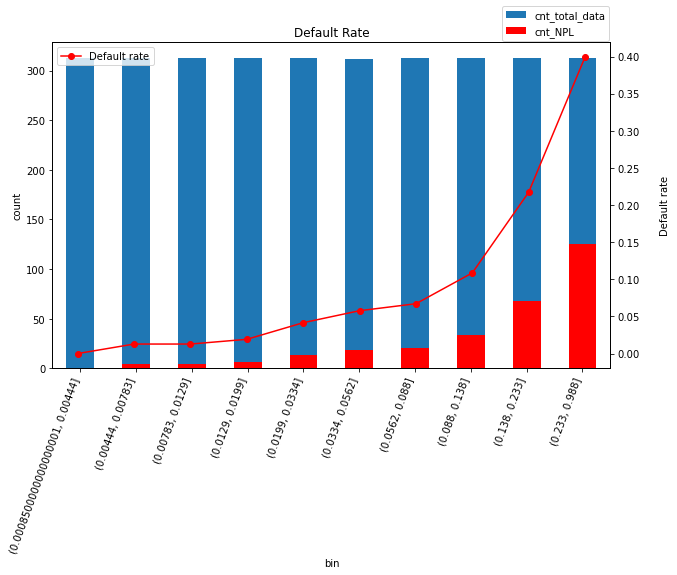

In [234]:
bin_,df_rate=plot_score_default_rate(x_test,col_target='default_flag',col_score='score',title='Default Rate')

It shows that the higher score that machine learning predict, the more likely our prediction will be correct

In [313]:
# Cumulative default
def cutoff_default(df, col_score, col_target):
    """ 
    Create dataframe of Pscore and default rate
    input:
        dataframe,
        probability column name,
        y true column name
    """
    df = df.sort_values(col_score)
    df['cum_total_default'] = np.cumsum(df[col_target])
    df['row'] = np.arange(1,len(df)+1)
#     tot_def = len(df)
    df['cum_default_rate'] = df['cum_total_default']/df['row']
#     .apply(lambda x: x/tot_def)
    return df[[col_score, 'cum_default_rate']]

In [314]:
def cutoff_default_plot(df, col_score, exp_appr_rate = 0.05,title1='Pscore', ax=None):
    """ 
    Plot Pscore vs default rate
    """
    df['diff'] = df['cum_default_rate']-exp_appr_rate
    df['diff_abs'] = df['diff'].abs()
    idx = np.argmin(np.array(df['diff_abs']))
    cutoff = df[col_score].values[idx]
    
    print('The {} threshold to cumulative default rate estimation {:.2%} : {}'.format(title1,exp_appr_rate,cutoff))
    if ax is None:
        ax = plt.gca()

    ax.plot(df[col_score], df['cum_default_rate'], color='b')
    ax.axvline(cutoff, color = 'r')
    ax.scatter(cutoff, exp_appr_rate, marker='x', color='k')
    ax.set_xticks([i*0.1 for i in range(1,11)])
    ax.set_yticks([i*0.1 for i in range(1,11)])
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1)

The Pscore threshold to cumulative default rate estimation 3.00% : 0.08805111050605774


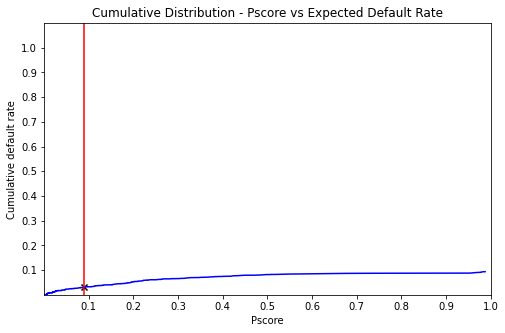

In [315]:

exp_appr_rate =0.03
scores = ['score']
col_target = 'default_flag'

# plot cutoff score
fig, ax = plt.subplots(figsize=(8,5))
for s in scores:
    dt = cutoff_default(x_test,
                   col_score=s,
                   col_target=col_target)
    cutoff_default_plot(dt,
                col_score=s,
                exp_appr_rate=exp_appr_rate,title1='Pscore',
                ax=ax)

plt.title('Cumulative Distribution - Pscore vs Expected Default Rate')
plt.xlabel('Pscore')
plt.ylabel('Cumulative default rate')
plt.show()

As we get 0.08805 as our threshold based on cumulative default rate estimation, we need to check how approval rate is by assuming score higher 0.08805

In [317]:
p_default=0.08805
score='score'
label='default_flag'

cnt_total_approved=len(x_test.loc[x_test[score]<=p_default])
cnt_total_all=len(x_test)

dt_temp=pd.DataFrame({'score':[p_default],'approval_rate':[cnt_total_approved/cnt_total_all]})
dt_temp

,score,approval_rate
0,0.08805,0.700224


In [318]:
#create credit scorecard by bin
def cumulative_apr_rate(dt,score,bin_):
    """ 
    Create dataframe of cumulative approval rate
    input:
        dataframe,
        probability column name,
        number of bin to create
    """
    df1=pd.DataFrame()
    bin_=np.linspace(0,1,bin_+1)
    for i in bin_:
        cnt_within_thre=len(dt.loc[dt[score]<=i])
        cnt_total=len(dt)
        if cnt_total >0:
            apr_rate=cnt_within_thre/cnt_total
        else:
            apr_rate=0
        dt_temp=pd.DataFrame({'bin':[round(i,2)],'cum_data':[cnt_within_thre],'approval_rate':[apr_rate]})
        df1=df1.append(dt_temp,ignore_index=True)
    return df1
def cumulative_npl_rate(dt,score,label,npl,bin_):
    """
    Create dataframe of cumulative npl rate
    input:
        dataframe,
        probability column name,
        label column name,
        npl value,
        number of bin to create
    """
    df1=pd.DataFrame()
    bin_=np.linspace(0,1,bin_+1)
    for i in bin_:
        cnt_npl=len(dt.loc[(dt[score]<=i)&(dt[label]==npl)])
        cnt_total=len(dt.loc[dt[score]<=i])
        if cnt_total >0:
            
            npl_rate=cnt_npl/cnt_total
        else:
            npl_rate=0
        dt_temp=pd.DataFrame({'bin':[round(i,2)],'cnt_npl':[cnt_npl],'cnt_total_approved':[cnt_total],'default_rate':[npl_rate]})
        df1=df1.append(dt_temp,ignore_index=True)
    return df1

def combined_npl_approval_rate(npl,apr,col):
    """
    Combine approval dataframe and default dataframe
    input:
        npl df,
        approval df,
        join key
    """
    final_=pd.merge(npl.reset_index(),apr,on=col,how='outer')[['bin','cnt_npl','cnt_total_approved','default_rate','cum_data','approval_rate']]
    return final_



In [319]:
# Call functions above to create credit scorecard
result_apr_cum=cumulative_apr_rate(x_test,'score',10)
npl_rate_cum=cumulative_npl_rate(x_test,'score','default_flag',1,10)
combined_npl_apr=combined_npl_approval_rate(npl_rate_cum,result_apr_cum,'bin')
combined_npl_apr['lower_bin_']=combined_npl_apr['bin'].shift(1)
combined_npl_apr['bin_range']=combined_npl_apr['lower_bin_'].astype('str').str.cat('-'+combined_npl_apr['bin'].astype('str'))

In [320]:
final=combined_npl_apr[combined_npl_apr['bin']!=0][['bin','default_rate','approval_rate']]
final.rename(columns={'bin':'threshold'})

,threshold,default_rate,approval_rate
1,0.1,0.032837,0.729946
2,0.2,0.052768,0.866091
3,0.3,0.065866,0.931608
4,0.4,0.074801,0.961329
5,0.5,0.082031,0.981783
6,0.6,0.085003,0.988814
7,0.7,0.086690,0.991691
8,0.8,0.087222,0.992969
9,0.9,0.087222,0.992969
10,1.0,0.093640,1.000000


# CONCLUSION

- The model has AUC 0.843357
- The threshold for achieving default rate below 3% and approval rate higher than 70% = 0.08805
- The credit scorecard that can help nontechnical team use our model aligning with their plan would be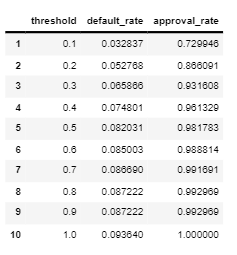